In [81]:
import torch
import matplotlib.pyplot as plt
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib


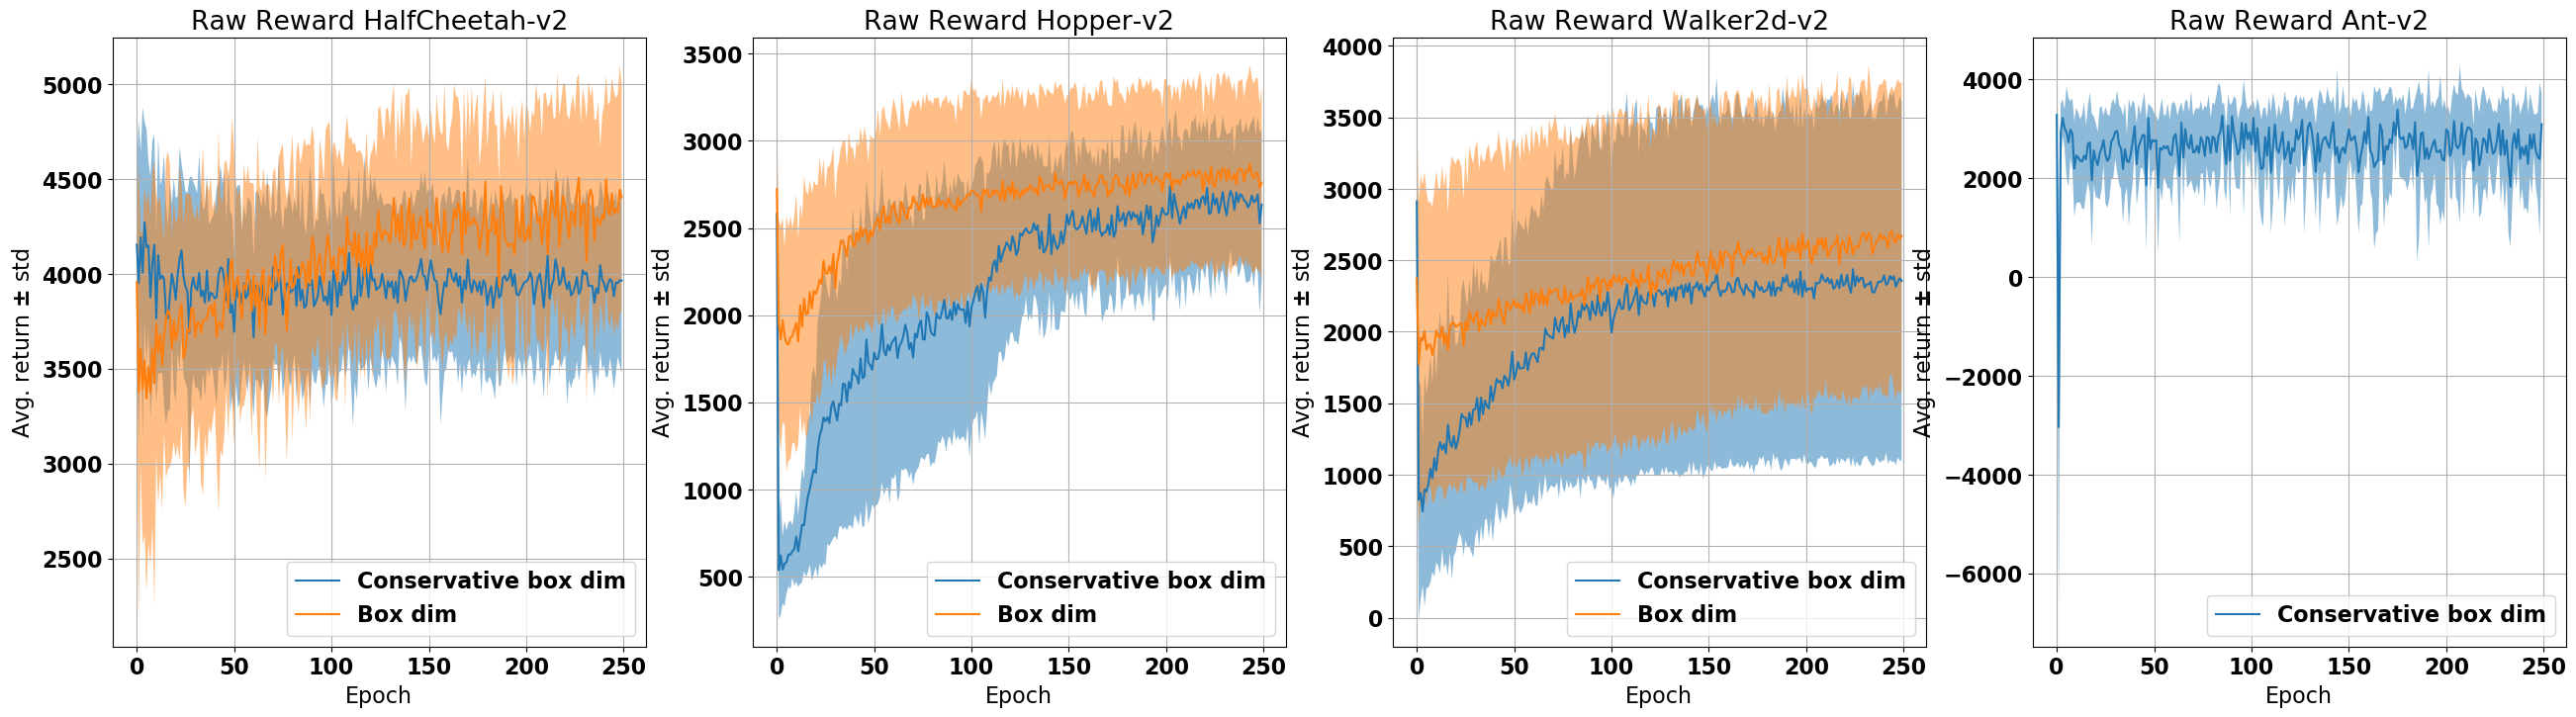

In [83]:
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2", "Ant-v2"]
init_names = ["identity", "madodiv", "identity", "identity"]

font = {'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, len(env_names), figsize=(32,8))

i = 0 
for env_name, init_name in zip(env_names, init_names):
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    ax[i].plot(means.T)
    ax[i].legend(['Conservative box dim', 'Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        ax[i].fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    ax[i].set_title(f"Raw Reward {env_name}")
    ax[i].set_ylabel(r"Avg. return $\pm$ std")
    ax[i].set_xlabel(r"Epoch")
    ax[i].grid()
    i+=1
    
#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.legend([i for i in range(10)])
#         plt.title(exp_name)
#         plt.figure()

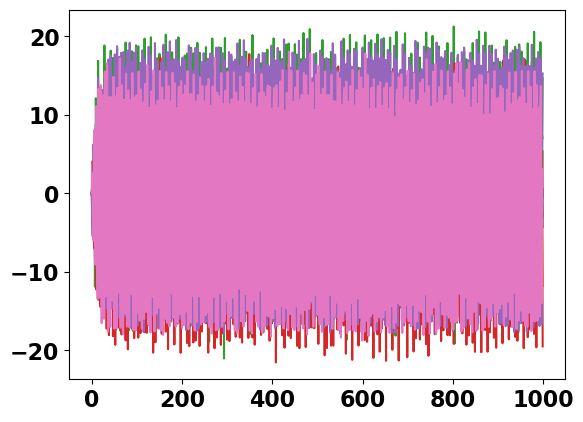

In [84]:
env_name = "HalfCheetah-v2"
env = gym.make(env_name)
data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']

obs, acts, rews, _  = do_rollout(env, policy_dict['identity'][7])
plt.plot(obs);

In [85]:
seed = 2; delta = 1
iden_mesh = BoxMesh(delta); iden_l = []
mdim_mesh = BoxMesh(delta); mdim_l = []

iden_policy = policy_dict['identity'][seed]
mdim_policy = policy_dict['mdim_div'][seed]

batch_size = 128

def do_mesh_rollout(trial_num):
    env.seed(trial_num)
    obs, acts, rews, _  = do_rollout(env, iden_policy)
    iden_obs = (obs - iden_policy.state_means)/(iden_policy.state_std)
    
    obs, acts, rews, _  = do_rollout(env, mdim_policy)
    mdim_obs = (obs - mdim_policy.state_means)/(mdim_policy.state_std)
    
    return iden_obs, mdim_obs
    

In [86]:
from torch.multiprocessing import Pool
with Pool() as pool:

    for i in range(200, 300):
        for j, res in enumerate(pool.imap(do_mesh_rollout, range(i*batch_size, i*batch_size+batch_size))):
            iden_obs, mdim_obs = res
           
            for o in iden_obs:
                if o in iden_mesh:
                    iden_mesh[o]+=1
                else:
                    iden_mesh[o]=1

            for o in mdim_obs:
                if o in mdim_mesh:
                    mdim_mesh[o]+=1
                else:
                    mdim_mesh[o]=1
                    
        iden_l.append(len(iden_mesh)); mdim_l.append(len(mdim_mesh))
        print(f"i; {i}, iden: {len(iden_mesh)}, mdim: {len(mdim_mesh)}, ratio: {len(mdim_mesh)/len(iden_mesh)}")


i; 200, iden: 5875, mdim: 2261, ratio: 0.38485106382978723


Process ForkPoolWorker-321:
Process ForkPoolWorker-324:
Process ForkPoolWorker-333:
Process ForkPoolWorker-334:
Process ForkPoolWorker-327:
Process ForkPoolWorker-330:
Process ForkPoolWorker-331:
Process ForkPoolWorker-325:
Process ForkPoolWorker-335:
Process ForkPoolWorker-322:
Process ForkPoolWorker-332:
Process ForkPoolWorker-326:
Process ForkPoolWorker-336:
Traceback (most recent call last):
Process ForkPoolWorker-323:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-329:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sgillen/miniconda3/envs/baselines/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sgillen/miniconda3/envs/baselines/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  Fil

KeyboardInterrupt: 

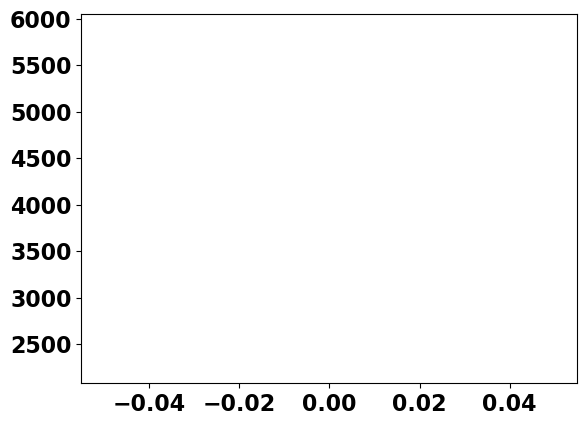

In [87]:
plt.plot(iden_l)
plt.plot(mdim_l)

In [88]:
6*28

168